# SegNet  
- Pytorch로 논문 구현  
- Data: CamVid (from Kaggle)
    - Train: 369개, Valid: 100개, Test: 232개
    
- accuracy를 측정할 metric으로는 mIoU를 사용  

# Packages and Modules

In [1]:
# packages and modules
import os
import time
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from pytorchtools import EarlyStopping, Metrics, FocalLoss
from segnet_utils import load_image_with_resize

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

# Load Data

In [3]:
# 클래스 디렉토리 데이터 불러오기
data = pd.read_csv('./camvid/11_class_dict.csv', index_col=0)
data

r    g    b
name                     
Sky         128  128  128
Building    128    0    0
Pole        192  192  128
Road        128   64  128
Sidewalk      0    0  192
Tree        128  128    0
SignSymbol  192  128  128
Fence        64   64  128
Car          64    0  128
Pedestrian   64   64    0
Bicyclist     0  128  192
unlabelled    0    0    0

In [4]:
rgb_data = {name:list(data.loc[name, :]) for name in data.index}
rgb_array = {idx:np.array(rgb) for idx, (_, rgb) in enumerate(rgb_data.items())}

In [5]:
width = 224
height = 224
num_classes = len(data) # 12 classes (11 object classes and 1 background)

# cuda setting
device = torch.device('cuda')
print(device)

cuda


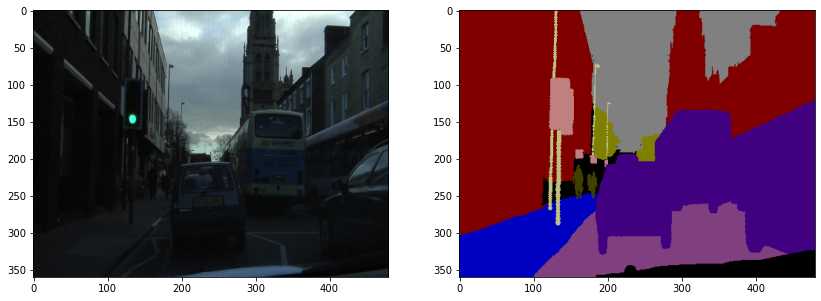

In [6]:
# show sample image
ex1 = Image.open('./camvid/train/train_images/0001TP_006690.png')
ex2 = Image.open('./camvid/train/train_labels/0001TP_006690_L.png')
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(ex1)
plt.subplot(122)
plt.imshow(ex2)
plt.show()

In [7]:
# load image data with resize
path = './camvid/'
train_image, train_label = load_image_with_resize(path, 
                                                  n_pixel_L=width, n_pixel_R=height, 
                                                  subset='train')
valid_image, valid_label = load_image_with_resize(path, 
                                                  n_pixel_L=width, n_pixel_R=height, 
                                                  subset='valid')
test_image, test_label = load_image_with_resize(path, 
                                                n_pixel_L=width, n_pixel_R=height, 
                                                subset='test')

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

In [8]:
# data 합치기 (총 701장)
data_images = np.concatenate((train_image,valid_image,test_image), axis=0)
data_labels = np.concatenate((train_label,valid_label,test_label), axis=0)

# shuffling
idx = np.arange(len(data_images))
np.random.shuffle(idx)
shuffled_images = data_images[idx]
shuffled_labels = data_labels[idx]

# divide train, valid and test data set
# train data: 500장
train_image = shuffled_images[:500]
train_label = shuffled_labels[:500]
# valid data: 100장
valid_image = shuffled_images[500:600]
valid_label = shuffled_labels[500:600]
# test data: 101장
test_image = shuffled_images[600:]
test_label = shuffled_labels[600:]

In [9]:
# image to 12 classes mask
def image2mask(labels):
    semantic_map = []
    for color in tqdm(list(rgb_data.values())):
        equality = np.equal(labels, color)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)

train_mask = image2mask(train_label)
valid_mask = image2mask(valid_label)
test_mask = image2mask(test_label)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
# custom data set
class CamVidDataset(Dataset):
    def __init__(self, transforms_, subset='train', predict_train=False):
        self.transforms = transforms.Compose(transforms_)
        if subset=='train':
            if predict_train:
                self.images = train_image[:100]
                self.labels = train_mask[:100]
            else:
                self.images = train_image
                self.labels = train_mask
        elif subset=='valid':
            self.images = valid_image
            self.labels = valid_mask
        else:
            self.images = test_image
            self.labels = test_mask
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]
        return self.transforms(images), self.transforms(labels)

In [11]:
batch_size = 12

transforms_ = [
    transforms.ToTensor(),
]

train_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='train'),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

valid_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='valid'),
    batch_size=len(valid_image),
    shuffle=True,
    drop_last=True
)

# Median Frequency Balancing

In [12]:
# class balance of train data set 
train_class_labels = list(rgb_data.keys())
train_class_count = [2925992, 4164714, 113525, 5769970, 771679, 1666212, 191065, 195738,
                     1040037, 97657, 48378, 607456]
print(train_class_labels)

['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree', 'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'unlabelled']


In [13]:
# median frequency balancing
weights = torch.tensor(train_class_count, dtype=torch.float32)
median_weights = weights.median()
median_frequency_balancing = median_weights/weights
median_frequency_balancing

tensor([ 0.2076,  0.1459,  5.3509,  0.1053,  0.7872,  0.3646,  3.1793,  3.1034,
         0.5841,  6.2203, 12.5565,  1.0000])

## Build Model

In [14]:
# load pre-trained vgg16
vgg16 = models.vgg16(pretrained=True)

In [15]:
# define encoder block module using pre-trained vgg16
class EncoderBlock(nn.Module):
    def __init__(self, index):
        super(EncoderBlock, self).__init__()
        # build encoder network (Conv + BN + ReLU)
        self.block = nn.Sequential(
            vgg16.features[index],
            nn.BatchNorm2d(vgg16.features[index].out_channels),
            nn.ReLU(inplace=True),
        )
                
    def forward(self, x):
        return self.block(x)

In [16]:
# define encoder block module
class DecoderBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DecoderBlock, self).__init__()
        # build decoder network (Conv + BN + ReLU)
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.block(x)

In [17]:
class SegNet(nn.Module):
    def __init__(self, num_filters=64, in_dim=3, out_dim=num_classes):
        super(SegNet, self).__init__()
        # define convolution layer indices of vgg16 
        self.vgg_conv_index = [0,2,5,7,10,12,14,17,19,21,24,26,28]
        
        ### stage 1, 2 has 2 of Conv layer + Batch Norm layer + ReLU activation layer
        ### stage 3, 4, 5 has 3 of Conv layer + Batch Norm layer + ReLU activation layer
        
        ######################### ENCODER #########################
        # define max pooling layer
        self.MaxPooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # first encoding
        self.encoder1 = EncoderBlock(self.vgg_conv_index[0])
        self.encoder2 = EncoderBlock(self.vgg_conv_index[1])
        # second encoding
        self.encoder3 = EncoderBlock(self.vgg_conv_index[2])
        self.encoder4 = EncoderBlock(self.vgg_conv_index[3])
        # third encoding
        self.encoder5 = EncoderBlock(self.vgg_conv_index[4])
        self.encoder6 = EncoderBlock(self.vgg_conv_index[5])
        self.encoder7 = EncoderBlock(self.vgg_conv_index[6])
        # fourth encoding
        self.encoder8 = EncoderBlock(self.vgg_conv_index[7])
        self.encoder9 = EncoderBlock(self.vgg_conv_index[8])
        self.encoder10 = EncoderBlock(self.vgg_conv_index[9])
        # fifth encoding
        self.encoder11 = EncoderBlock(self.vgg_conv_index[10])
        self.encoder12 = EncoderBlock(self.vgg_conv_index[11])
        self.encoder13 = EncoderBlock(self.vgg_conv_index[12])
        
        ###########################################################
        ######################## SYMMETRIC ########################
        ###########################################################
        
        ######################### DECODER #########################
        # define max-pooling indices layer
        self.MaxUnPooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # first decoding
        self.decoder1 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder2 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder3 = DecoderBlock(num_filters*8, num_filters*8)
        # second decoding
        self.decoder4 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder5 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder6 = DecoderBlock(num_filters*8, num_filters*4)
        # third decoding
        self.decoder7 = DecoderBlock(num_filters*4, num_filters*4)
        self.decoder8 = DecoderBlock(num_filters*4, num_filters*4)
        self.decoder9 = DecoderBlock(num_filters*4, num_filters*2)
        # fourth decoding
        self.decoder10 = DecoderBlock(num_filters*2, num_filters*2)
        self.decoder11 = DecoderBlock(num_filters*2, num_filters)
        # fifth decoding
        self.decoder12 = DecoderBlock(num_filters, num_filters)
        self.decoder13 = DecoderBlock(num_filters, out_dim)
        # softmax classifier
        self.classifier = nn.Softmax()
        
    def forward(self, x):
        ######################### ENCODING #########################
        # stage 1
        size1 = x.size()
        x = self.encoder1(x)
        x = self.encoder2(x)
        x, idx1 = self.MaxPooling(x)
        # stage 2
        size2 = x.size()
        x = self.encoder3(x)
        x = self.encoder4(x)
        x, idx2 = self.MaxPooling(x)
        # stage 3
        size3 = x.size()
        x = self.encoder5(x)
        x = self.encoder6(x)
        x = self.encoder7(x)
        x, idx3 = self.MaxPooling(x)
        # stage 4
        size4 = x.size()
        x = self.encoder8(x)
        x = self.encoder9(x)
        x = self.encoder10(x)
        x, idx4 = self.MaxPooling(x)
        # stage 5
        size5 = x.size()
        x = self.encoder11(x)
        x = self.encoder12(x)
        x = self.encoder13(x)
        x, idx5 = self.MaxPooling(x)
        
        ######################### DECODING #########################
        # stage 5
        x = self.MaxUnPooling(x, idx5, output_size=size5)
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        # stage 4
        x = self.MaxUnPooling(x, idx4, output_size=size4)
        x = self.decoder4(x)
        x = self.decoder5(x)
        x = self.decoder6(x)
        # stage 3
        x = self.MaxUnPooling(x, idx3, output_size=size3)
        x = self.decoder7(x)
        x = self.decoder8(x)
        x = self.decoder9(x)
        # stage 2
        x = self.MaxUnPooling(x, idx2, output_size=size2)
        x = self.decoder10(x)
        x = self.decoder11(x)
        # stage 1
        x = self.MaxUnPooling(x, idx1, output_size=size1)
        x = self.decoder12(x)
        out = self.decoder13(x)
        # apply softmax activation function
        softmax_output = self.classifier(out)
        
        return out, softmax_output

In [18]:
model = SegNet().to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
      EncoderBlock-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
      EncoderBlock-8         [-1, 64, 224, 224]               0
         MaxPool2d-9  [[-1, 64, 112, 112], [-1, 64, 112, 112]]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
      BatchNorm2d-11        [-1, 128, 112, 112]             256
             ReLU-12        [-1, 128, 112, 112]               0
     EncoderBlock-13        [-1, 128, 112, 112]               0
           Conv2d-14    

# Set Loss function, Optimizer, learning rate scheduler and early stopping  
- loss : focal loss for semantic segmentation  
$$CE\left(p_t\right)=-\log\left(p_t\right)$$  
$$FL\left(p_t\right)=\alpha_t\left(1-p_t\right)^{\gamma}\times CE\left(p_t\right)$$  
$$\Rightarrow -\alpha\left(1-p_t\right)^{\gamma}\log\left(p_t\right)$$  

- class imbalance  
- using median frequency balancing  
$$weight = freq\, median \,/\, freq(c)$$

In [19]:
# set learning rate scheduler to reduce loss
lr = 0.0001
model_save_path = './model/checkpoint.pt'
# loss_func = FocalLoss(alpha=0.25, gamma=2, reduction='mean').to(device)
loss_func = nn.CrossEntropyLoss(weight=median_frequency_balancing).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5, verbose=True)
early_stopping = EarlyStopping(patience=40, verbose=True, path=model_save_path)
metric = Metrics(n_classes=num_classes, dim=1) # mIoU

# Train Model

In [20]:
# define model training function
def train(model, 
          train_data, 
          validation_data,
          epochs,
          learning_rate_scheduler=False,
          early_stop=False):
    # create empty list to append losses and miou of train, valid
    loss_list, val_loss_list = [], []
    miou_list, val_miou_list = [], []
    # train the model
    model.train()
    starting = time.time()
    # start training
    for epoch in tqdm(range(epochs)):
        init_time = time.time()
        # train by batch
        for train_images, train_labels in train_data:
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)
            # initialize the gradient to 0
            optimizer.zero_grad()
            
            output_images, _ = model(train_images)
            loss = loss_func(output_images, train_labels)
            train_miou = metric.get_miou(output_images, train_labels)
            # update loss and optimizer
            loss.backward()
            optimizer.step()
            
        end_time = time.time()
        loss_list.append(loss.item())
        miou_list.append(train_miou.item())
        # check epoch, loss, miou and time
        print(f'\n[Epoch {epoch+1}/{epochs}]'
              f'  [Loss: {loss.item():.3f}]'
              f'  [mIoU: {train_miou.item():.3f}]'
              f'  [time: {end_time-init_time:.3f}s]')
                
        # validate the model
        with torch.no_grad():
            for val_images, val_labels in validation_data:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                
                val_outputs, _ = model(val_images)
                val_loss = loss_func(val_outputs, val_labels)
                val_miou = metric.get_miou(val_outputs, val_labels)
                
                if learning_rate_scheduler:
                    lr_scheduler.step(val_loss)
                
            val_loss_list.append(val_loss.item())
            val_miou_list.append(val_miou.item())
            # check loss and miou of validation
            print(f'[validation loss: {val_loss.item():.3f}]'
                  f'   [validation mIoU: {val_miou.item():.3f}]')
            
        # set early stopping
        if early_stop:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print('\n##########################\n'
                      '##### Early Stopping #####\n'
                      '##########################')
                break
    # if we not set early stopping, the model save at the end of training
    if early_stop==False:
        torch.save(model.state_dict(), model_save_path)
        
    ending = time.time()
    print(f'\nTotal time for training is {ending-starting:.3f}s\n'
          'Saving model ...')
    
    return model, loss_list, val_loss_list, miou_list, val_miou_list

In [21]:
# model training
EPOCH = 500

model, train_loss, valid_loss, train_miou, valid_miou = train(
    model,
    train_loader,
    validation_data=valid_loader,
    epochs=EPOCH,
    learning_rate_scheduler=True,
    early_stop=False
)

  0%|          | 0/500 [00:00<?, ?it/s]


[Epoch 1/500]  [Loss: 0.836]  [mIoU: 0.079]  [time: 6.073s]
[validation loss: 1.001]   [validation mIoU: 0.081]

[Epoch 2/500]  [Loss: 0.886]  [mIoU: 0.194]  [time: 5.631s]
[validation loss: 0.840]   [validation mIoU: 0.187]

[Epoch 3/500]  [Loss: 0.594]  [mIoU: 0.237]  [time: 5.633s]
[validation loss: 0.691]   [validation mIoU: 0.240]

[Epoch 4/500]  [Loss: 0.655]  [mIoU: 0.312]  [time: 5.656s]
[validation loss: 0.606]   [validation mIoU: 0.298]

[Epoch 5/500]  [Loss: 0.472]  [mIoU: 0.357]  [time: 5.662s]
[validation loss: 0.542]   [validation mIoU: 0.355]

[Epoch 6/500]  [Loss: 0.462]  [mIoU: 0.377]  [time: 5.665s]
[validation loss: 0.485]   [validation mIoU: 0.398]

[Epoch 7/500]  [Loss: 0.371]  [mIoU: 0.489]  [time: 5.665s]
[validation loss: 0.450]   [validation mIoU: 0.413]

[Epoch 8/500]  [Loss: 0.350]  [mIoU: 0.417]  [time: 5.675s]
[validation loss: 0.433]   [validation mIoU: 0.436]

[Epoch 9/500]  [Loss: 0.284]  [mIoU: 0.510]  [time: 5.669s]
[validation loss: 0.411]   [validat

[validation loss: 0.423]   [validation mIoU: 0.586]

[Epoch 73/500]  [Loss: 0.098]  [mIoU: 0.789]  [time: 5.682s]
[validation loss: 0.419]   [validation mIoU: 0.584]

[Epoch 74/500]  [Loss: 0.091]  [mIoU: 0.769]  [time: 5.713s]
[validation loss: 0.418]   [validation mIoU: 0.584]

[Epoch 75/500]  [Loss: 0.089]  [mIoU: 0.778]  [time: 5.704s]
[validation loss: 0.436]   [validation mIoU: 0.585]

[Epoch 76/500]  [Loss: 0.095]  [mIoU: 0.780]  [time: 5.738s]
[validation loss: 0.431]   [validation mIoU: 0.584]

[Epoch 77/500]  [Loss: 0.094]  [mIoU: 0.771]  [time: 5.702s]
[validation loss: 0.417]   [validation mIoU: 0.583]

[Epoch 78/500]  [Loss: 0.090]  [mIoU: 0.780]  [time: 5.687s]
[validation loss: 0.421]   [validation mIoU: 0.585]

[Epoch 79/500]  [Loss: 0.090]  [mIoU: 0.769]  [time: 5.686s]
[validation loss: 0.430]   [validation mIoU: 0.586]

[Epoch 80/500]  [Loss: 0.090]  [mIoU: 0.756]  [time: 5.681s]
[validation loss: 0.424]   [validation mIoU: 0.589]

[Epoch 81/500]  [Loss: 0.088]  [mIo

[validation loss: 0.437]   [validation mIoU: 0.592]

[Epoch 143/500]  [Loss: 0.078]  [mIoU: 0.810]  [time: 5.698s]
[validation loss: 0.434]   [validation mIoU: 0.592]

[Epoch 144/500]  [Loss: 0.076]  [mIoU: 0.793]  [time: 5.690s]
[validation loss: 0.437]   [validation mIoU: 0.593]

[Epoch 145/500]  [Loss: 0.073]  [mIoU: 0.808]  [time: 5.685s]
[validation loss: 0.437]   [validation mIoU: 0.592]

[Epoch 146/500]  [Loss: 0.083]  [mIoU: 0.818]  [time: 5.679s]
[validation loss: 0.436]   [validation mIoU: 0.591]

[Epoch 147/500]  [Loss: 0.081]  [mIoU: 0.786]  [time: 5.675s]
Epoch   147: reducing learning rate of group 0 to 3.1250e-06.
[validation loss: 0.435]   [validation mIoU: 0.592]

[Epoch 148/500]  [Loss: 0.078]  [mIoU: 0.796]  [time: 5.694s]
[validation loss: 0.434]   [validation mIoU: 0.593]

[Epoch 149/500]  [Loss: 0.077]  [mIoU: 0.822]  [time: 5.680s]
[validation loss: 0.437]   [validation mIoU: 0.593]

[Epoch 150/500]  [Loss: 0.077]  [mIoU: 0.788]  [time: 5.678s]
[validation loss: 


[Epoch 212/500]  [Loss: 0.074]  [mIoU: 0.797]  [time: 5.688s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 213/500]  [Loss: 0.076]  [mIoU: 0.806]  [time: 5.671s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 214/500]  [Loss: 0.076]  [mIoU: 0.797]  [time: 5.693s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 215/500]  [Loss: 0.078]  [mIoU: 0.768]  [time: 5.699s]
[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 216/500]  [Loss: 0.075]  [mIoU: 0.807]  [time: 5.687s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 217/500]  [Loss: 0.075]  [mIoU: 0.802]  [time: 5.697s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 218/500]  [Loss: 0.076]  [mIoU: 0.775]  [time: 5.702s]
[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 219/500]  [Loss: 0.075]  [mIoU: 0.782]  [time: 5.689s]
[validation loss: 0.439]   [validation mIoU: 0.593]

[Epoch 220/500]  [Loss: 0.072]  [mIoU: 0.806]  [time: 5.695s]
[validation loss:


[Epoch 282/500]  [Loss: 0.076]  [mIoU: 0.813]  [time: 5.688s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 283/500]  [Loss: 0.075]  [mIoU: 0.815]  [time: 5.719s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 284/500]  [Loss: 0.075]  [mIoU: 0.778]  [time: 5.679s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 285/500]  [Loss: 0.077]  [mIoU: 0.805]  [time: 5.696s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 286/500]  [Loss: 0.074]  [mIoU: 0.809]  [time: 5.694s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 287/500]  [Loss: 0.080]  [mIoU: 0.779]  [time: 5.682s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 288/500]  [Loss: 0.075]  [mIoU: 0.803]  [time: 5.707s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 289/500]  [Loss: 0.075]  [mIoU: 0.809]  [time: 5.699s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 290/500]  [Loss: 0.079]  [mIoU: 0.794]  [time: 5.702s]
[validation loss:

[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 353/500]  [Loss: 0.081]  [mIoU: 0.742]  [time: 5.677s]
[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 354/500]  [Loss: 0.079]  [mIoU: 0.772]  [time: 5.683s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 355/500]  [Loss: 0.078]  [mIoU: 0.787]  [time: 5.684s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 356/500]  [Loss: 0.088]  [mIoU: 0.812]  [time: 5.690s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 357/500]  [Loss: 0.074]  [mIoU: 0.815]  [time: 5.693s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 358/500]  [Loss: 0.081]  [mIoU: 0.807]  [time: 5.702s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 359/500]  [Loss: 0.077]  [mIoU: 0.782]  [time: 5.682s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 360/500]  [Loss: 0.075]  [mIoU: 0.794]  [time: 5.677s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 361/500]  [Loss: 0.0


[Epoch 424/500]  [Loss: 0.074]  [mIoU: 0.806]  [time: 5.694s]
[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 425/500]  [Loss: 0.079]  [mIoU: 0.797]  [time: 5.703s]
[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 426/500]  [Loss: 0.077]  [mIoU: 0.784]  [time: 5.689s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 427/500]  [Loss: 0.090]  [mIoU: 0.716]  [time: 5.692s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 428/500]  [Loss: 0.074]  [mIoU: 0.805]  [time: 5.691s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 429/500]  [Loss: 0.080]  [mIoU: 0.786]  [time: 5.680s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 430/500]  [Loss: 0.076]  [mIoU: 0.798]  [time: 5.679s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 431/500]  [Loss: 0.081]  [mIoU: 0.784]  [time: 5.695s]
[validation loss: 0.439]   [validation mIoU: 0.592]

[Epoch 432/500]  [Loss: 0.079]  [mIoU: 0.750]  [time: 5.692s]
[validation loss:

[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 496/500]  [Loss: 0.077]  [mIoU: 0.798]  [time: 5.723s]
[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 497/500]  [Loss: 0.075]  [mIoU: 0.805]  [time: 5.737s]
[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 498/500]  [Loss: 0.074]  [mIoU: 0.796]  [time: 5.730s]
[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 499/500]  [Loss: 0.087]  [mIoU: 0.724]  [time: 5.708s]
[validation loss: 0.440]   [validation mIoU: 0.592]

[Epoch 500/500]  [Loss: 0.074]  [mIoU: 0.804]  [time: 5.695s]
[validation loss: 0.440]   [validation mIoU: 0.592]

Total time for training is 3115.122s
Saving model ...


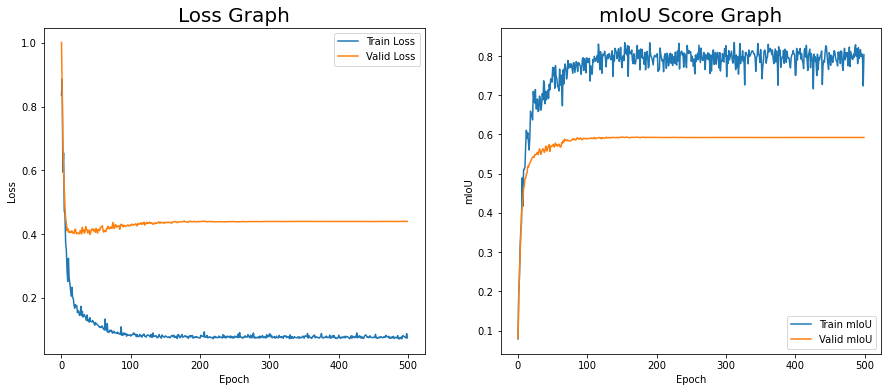

In [22]:
# check losses and miou scores graph
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_title('Loss Graph', fontsize=20)
ax[0].plot(np.arange(len(train_loss)), train_loss, label='Train Loss')
ax[0].plot(np.arange(len(valid_loss)), valid_loss, label='Valid Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[1].set_title('mIoU Score Graph', fontsize=20)
ax[1].plot(np.arange(len(train_miou)), train_miou, label='Train mIoU')
ax[1].plot(np.arange(len(valid_miou)), valid_miou, label='Valid mIoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('mIoU')
ax[1].legend(loc='best')
fig.show()

# Test

In [23]:
# load saved model
model = SegNet().to(device)
model.load_state_dict(torch.load('./model/checkpoint.pt'))

<All keys matched successfully>

In [24]:
# load test data
test_loader = DataLoader(
    CamVidDataset(transforms_, subset='test'),
    batch_size=len(test_image),
    drop_last=True,
    shuffle=False
)

In [25]:
# test
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        # predict
        test_outputs, _ = model(test_images)
        loss = loss_func(test_outputs, test_labels)
        test_miou = metric.get_miou(test_outputs, test_labels)
        print(f'Test Loss: {loss.item():.3f},'
              f'  Test mIoU: {test_miou:.3f}')

Test Loss: 0.403,  Test mIoU: 0.615


In [26]:
# 12 classes channels to 3 RGB channels
def map_class_to_rgb(p):
    return rgb_array[p[0]]

def mask2rgb(images):
    rgb_img_list = []
    for img in tqdm(images):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1,2,0))
        img = np.argmax(img, axis=-1)
        rgb_img = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(img, -1))
        rgb_img_list.append(rgb_img)
    return np.array(rgb_img_list)

test_result = mask2rgb(test_outputs)

  0%|          | 0/101 [00:00<?, ?it/s]

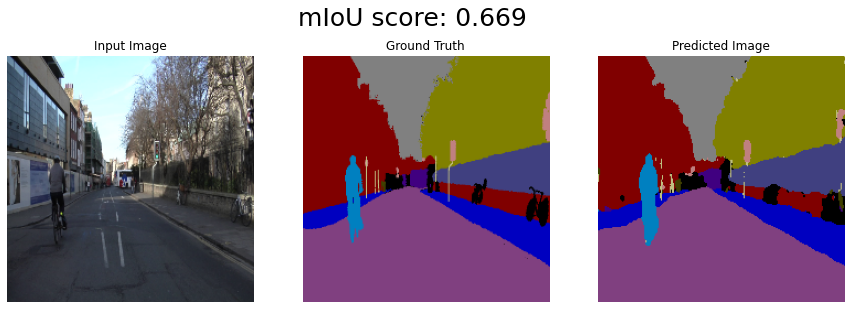

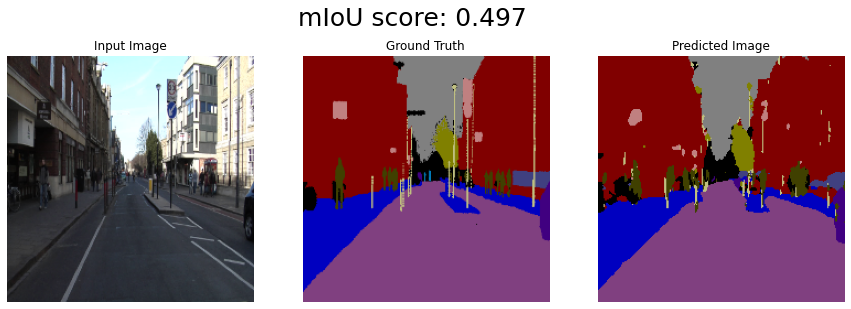

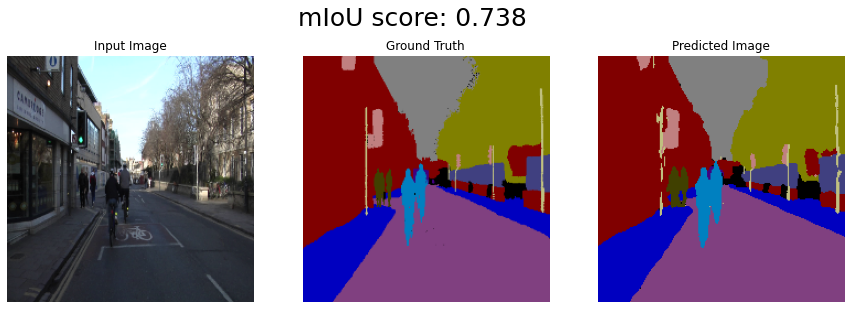

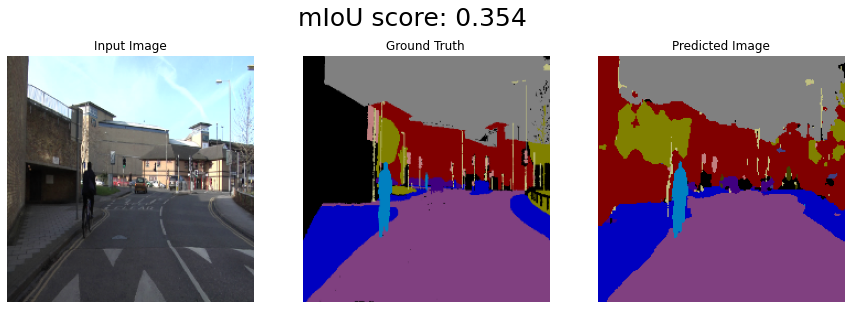

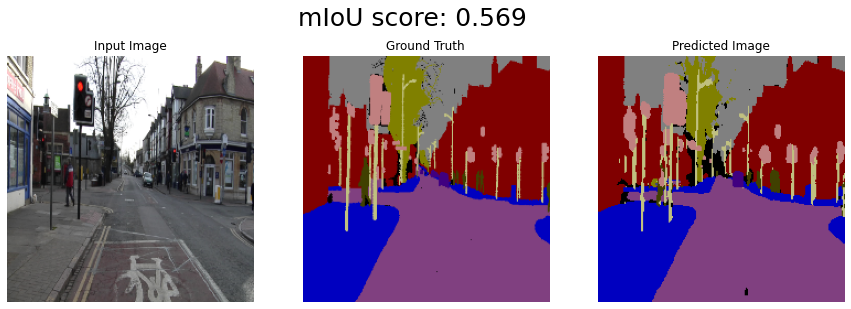

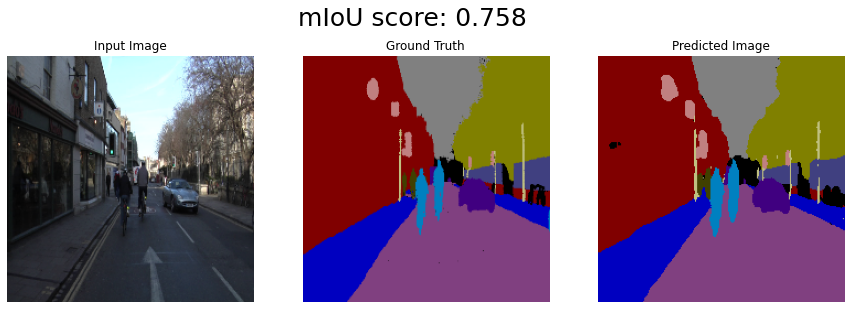

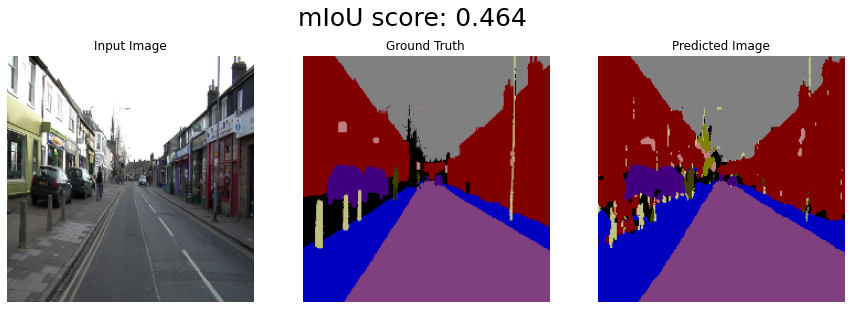

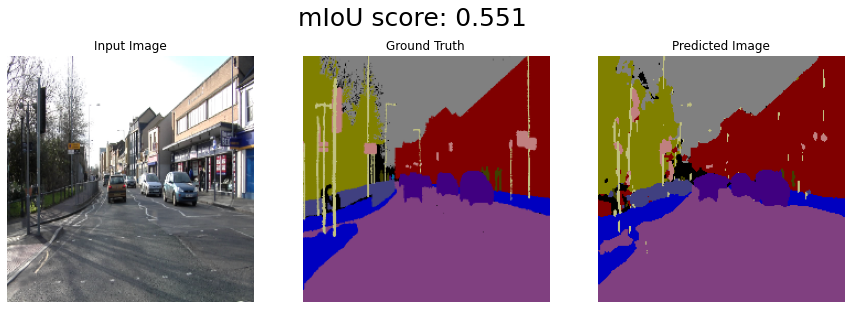

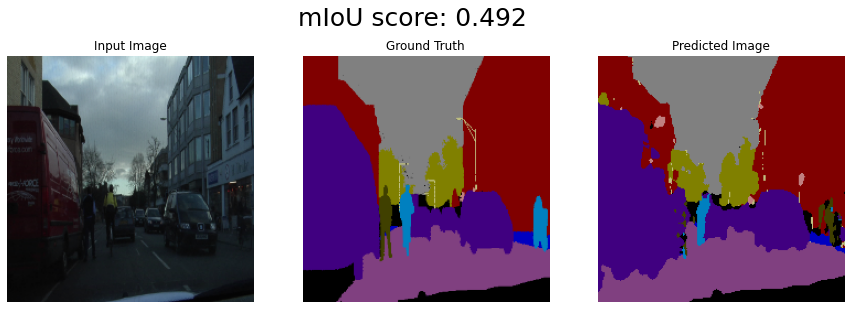

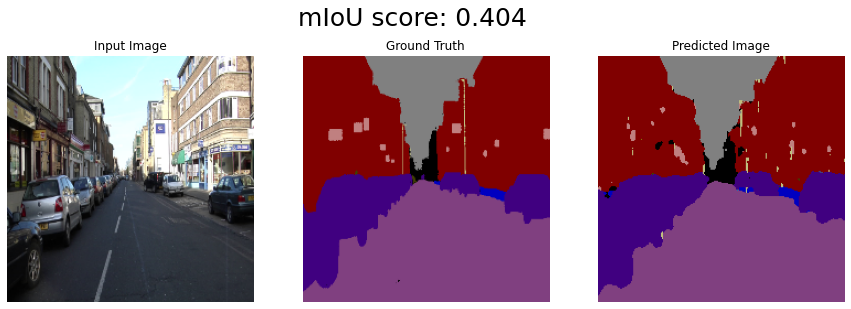

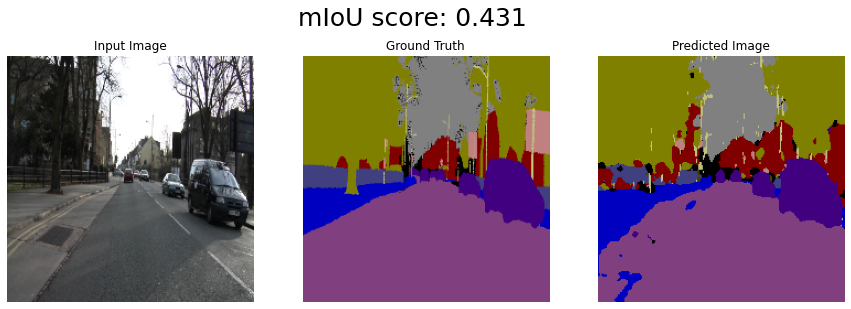

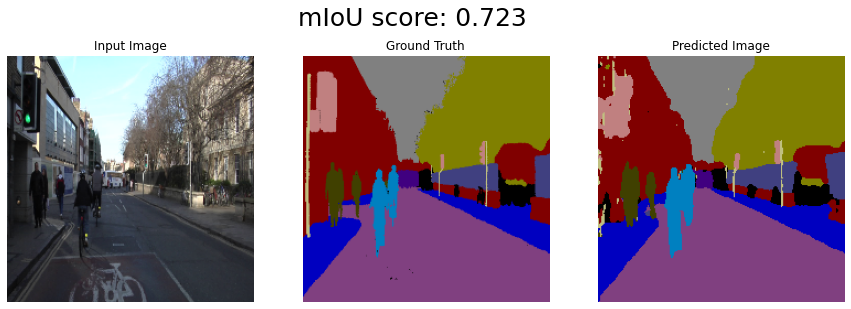

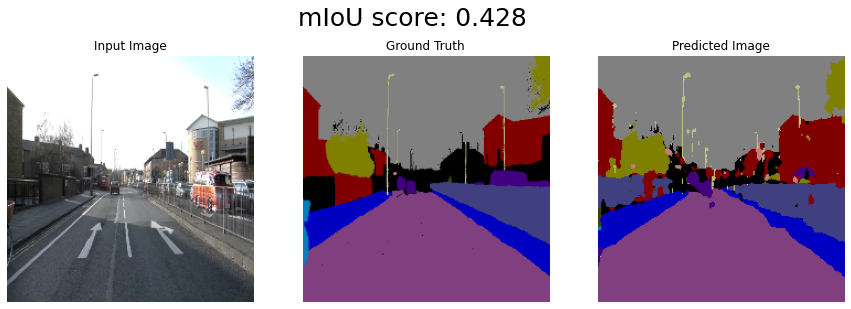

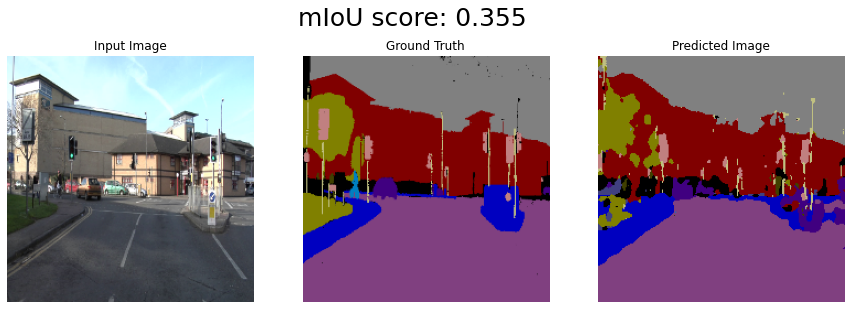

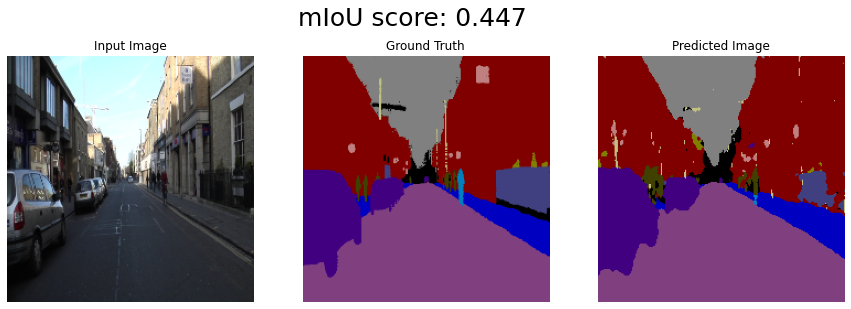

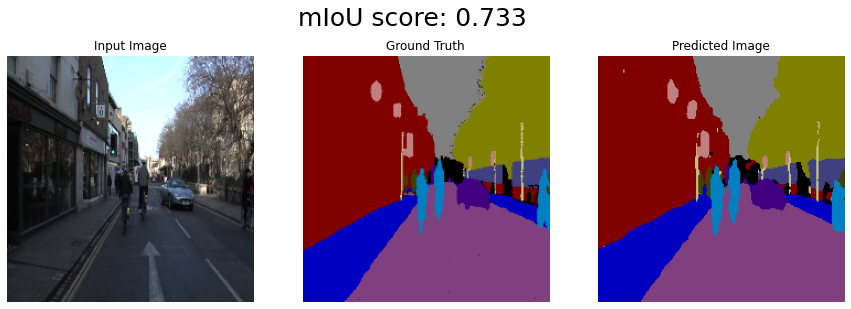

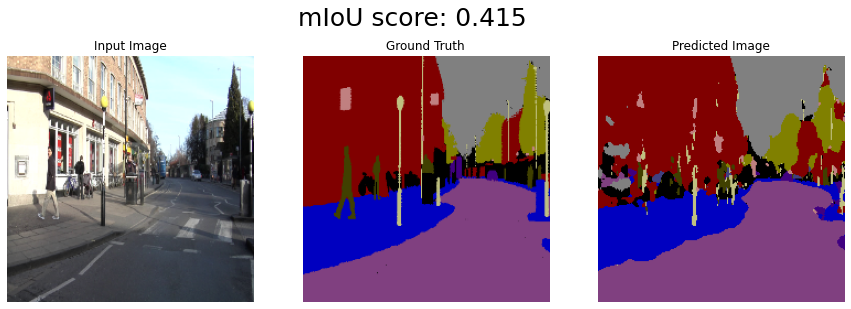

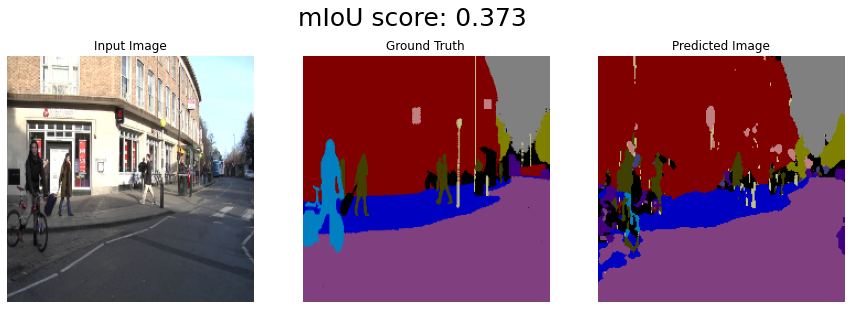

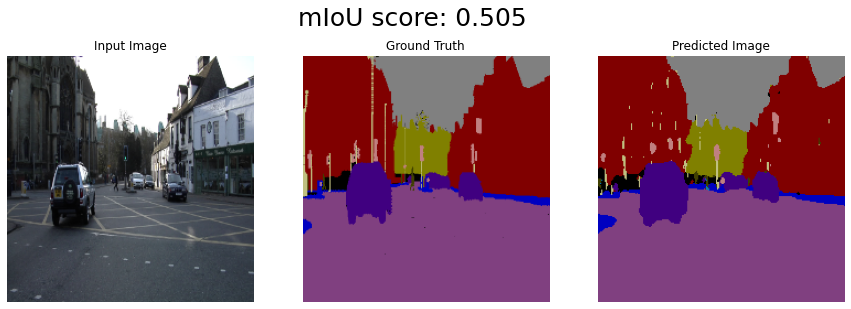

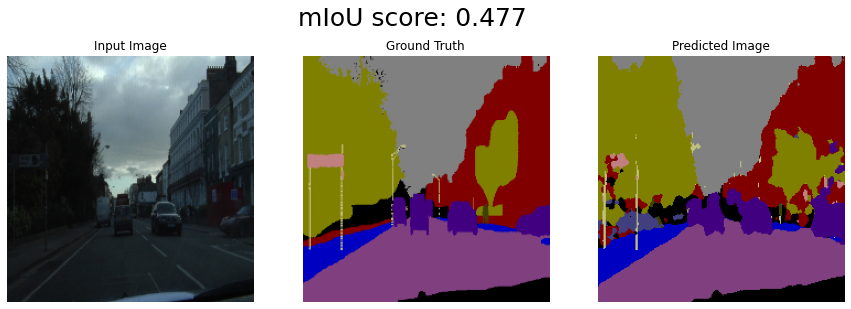

In [31]:
# show test outputs with miou score
test_metric = Metrics(n_classes=num_classes, dim=0)

def show_result(image, label, mask, model_pred, rgb_pred, ncols):
    for i in range(ncols):
        # get miou score
        miou = test_metric.get_miou(mask[i], model_pred[i])
        # plot images
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        fig.suptitle(f'mIoU score: {miou:.3f}', fontsize=25)
        ax[0].imshow(image[i])
        ax[0].axis('off')
        ax[0].set_title('Input Image')
        ax[1].imshow(label[i])
        ax[1].axis('off')
        ax[1].set_title(f'Ground Truth')
        ax[2].imshow(rgb_pred[i])
        ax[2].axis('off')
        ax[2].set_title(f'Predicted Image')
        fig.show()
        
show_result(test_image, test_label, test_labels, test_outputs, test_result, 20)

In [28]:
# model이 train data에 대해 잘 훈련됐는지 확인
train_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='train', predict_train=True),
    batch_size=100,
    shuffle=False,
    drop_last=True
)

In [29]:
# test
with torch.no_grad():
    for train_images, train_labels in train_loader:
        train_images = train_images.to(device)
        train_labels = train_labels.to(device)
        # predict
        train_outputs, _ = model(train_images)
        loss = loss_func(train_outputs, train_labels)
        test_miou = metric.get_miou(train_outputs, train_labels)
        print(f'Train Loss: {loss.item():.3f},'
              f'  Train mIoU: {test_miou:.3f}')
        
train_result = mask2rgb(train_outputs)

Train Loss: 0.072,  Train mIoU: 0.808


  0%|          | 0/100 [00:00<?, ?it/s]

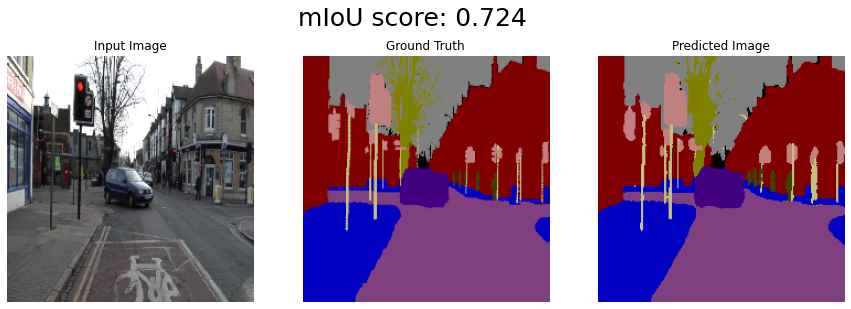

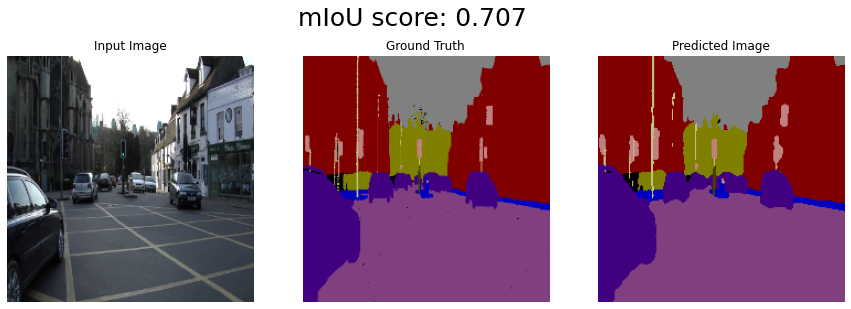

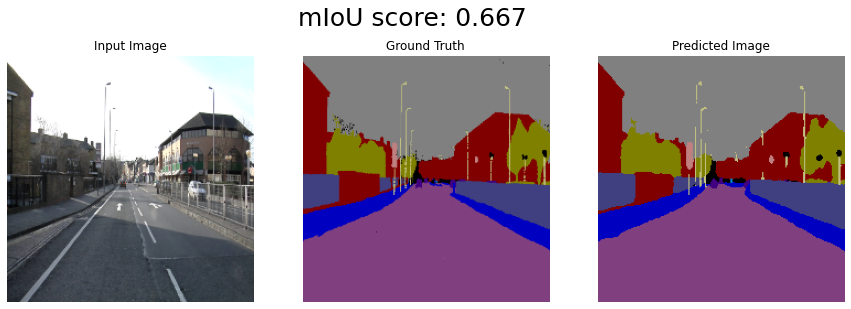

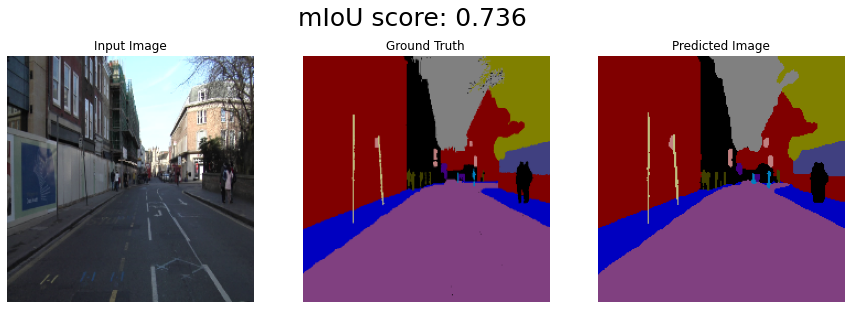

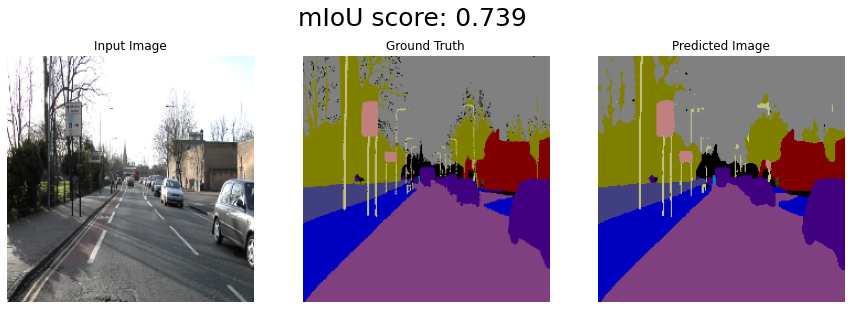

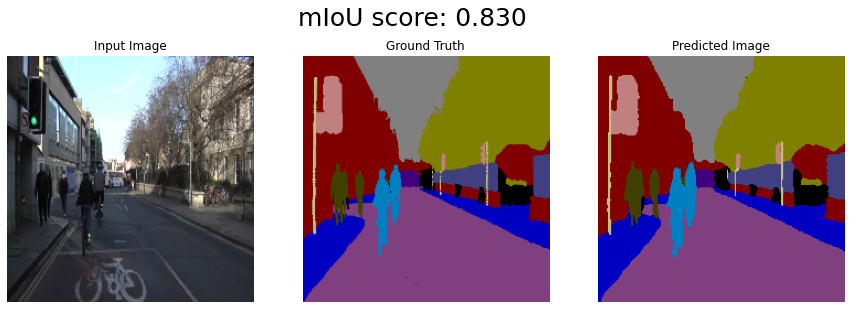

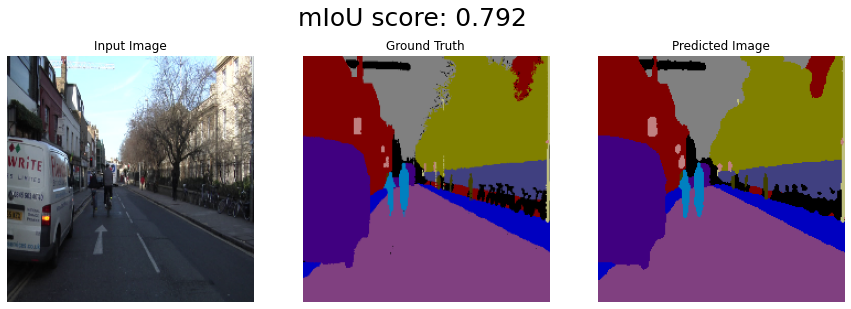

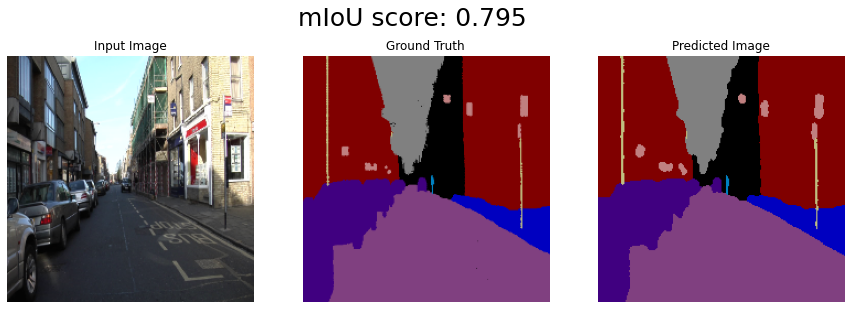

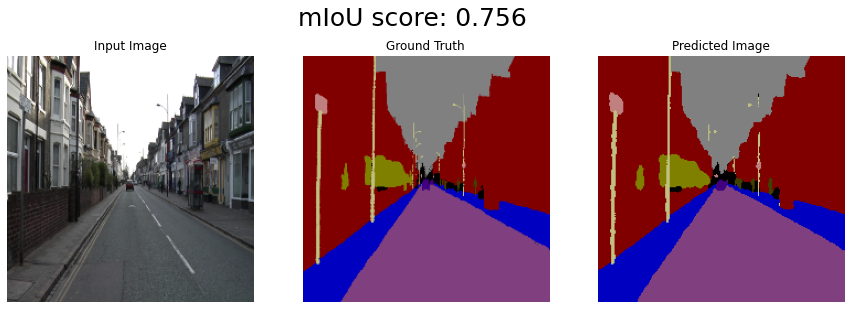

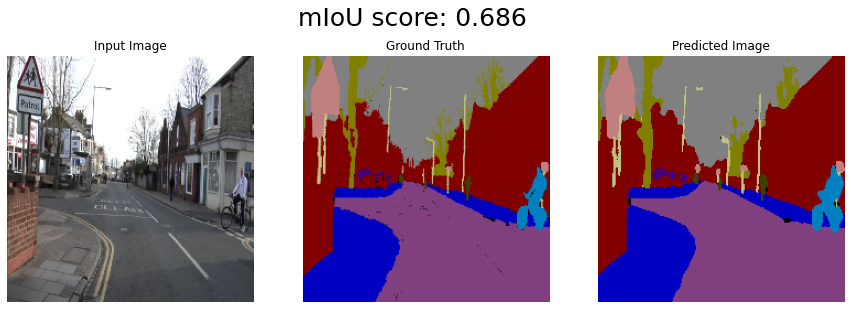

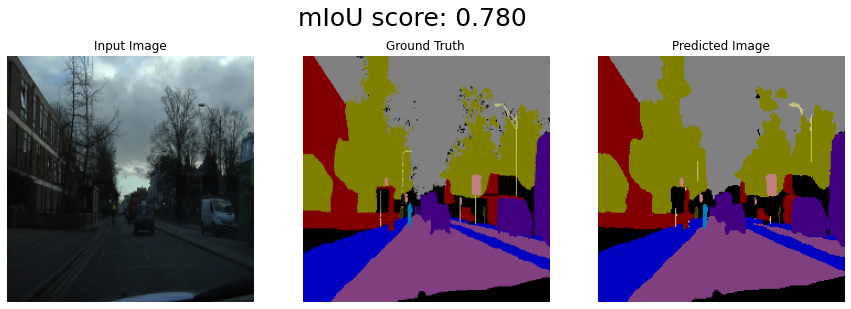

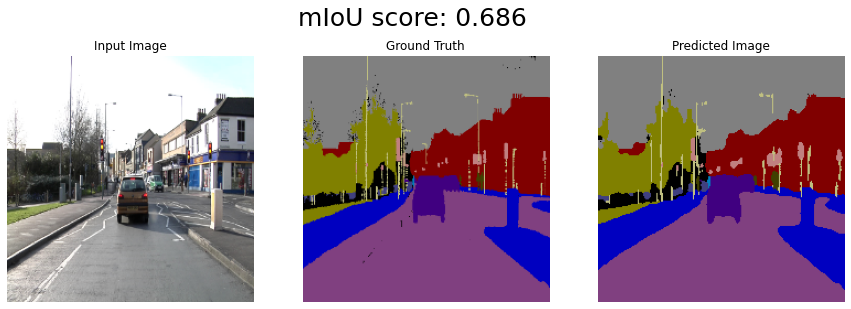

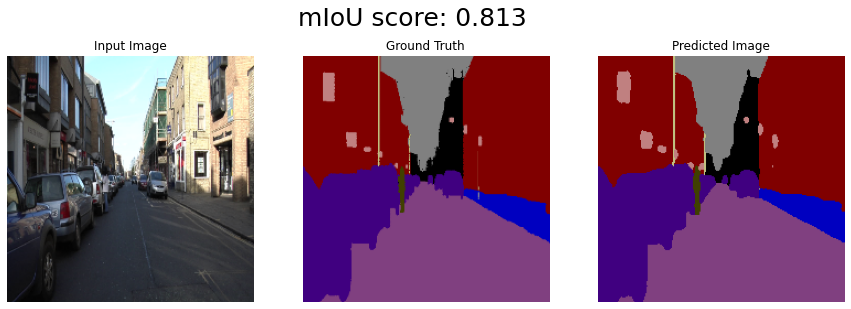

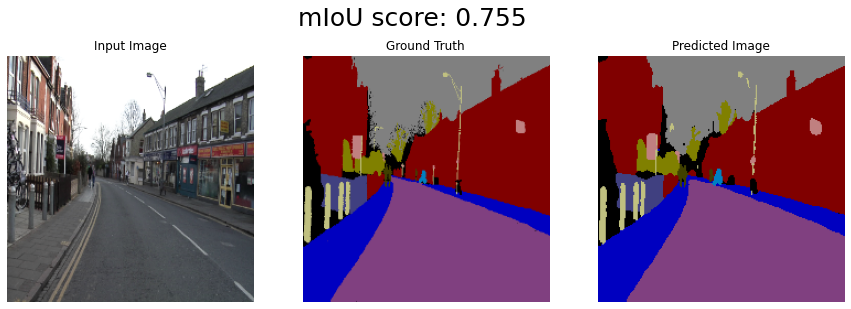

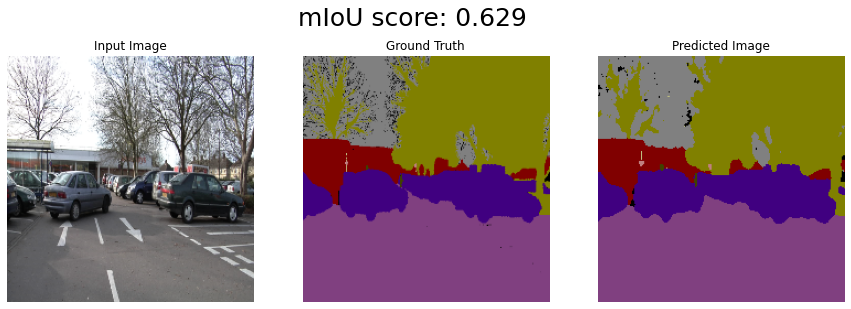

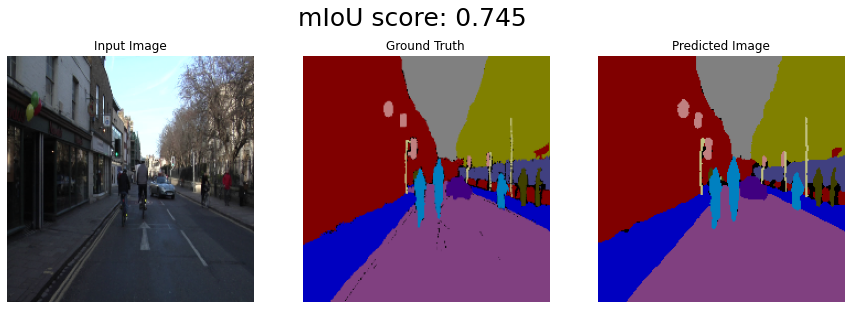

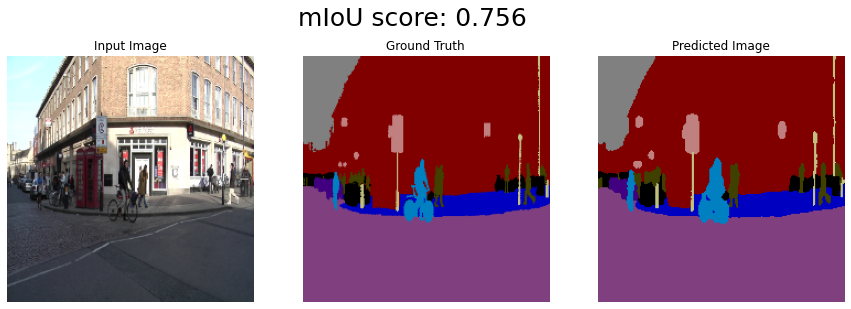

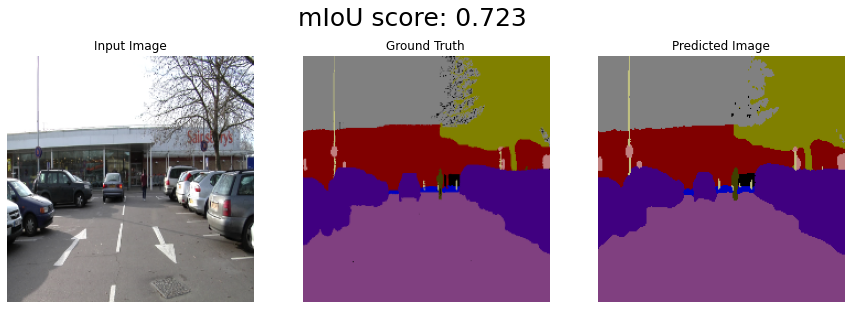

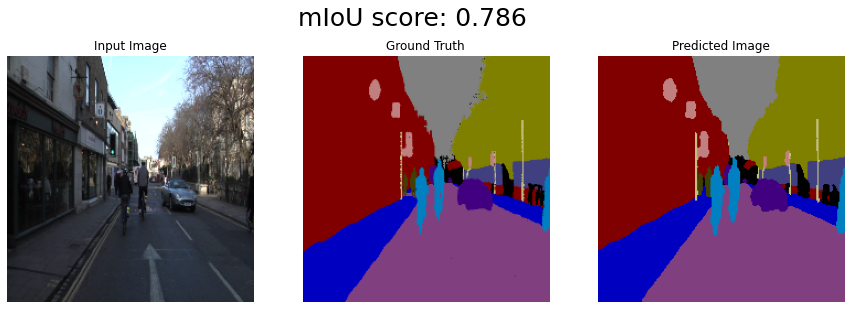

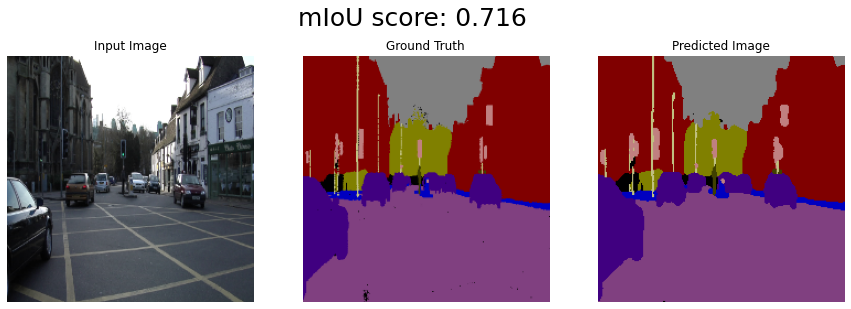

In [32]:
show_result(train_image, train_label, train_labels, train_outputs, train_result, 20)